# Plant Seedings
https://www.kaggle.com/c/plant-seedlings-classification

In [1]:
# Shell script for preparing data
# cd data
# mkdir plantseedings
# cd plantseedings
# kg download -u <username> -p <password> -c plant-seedlings-classification -f sample_submission.csv.zip
# kg download -u <username> -p <password> -c plant-seedlings-classification -f test.zip
# kg download -u <username> -p <password> -c plant-seedlings-classification -f train.zip

# unzip -q sample_submission.csv.zip
# unzip -q test.zip
# unzip -q train.zip

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from fastai.imports import *

In [4]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

# Data Prep

In [1]:
from glob import glob
import pandas as pd

df = pd.DataFrame(columns=["file", "species"])

for image in glob("/home/ubuntu/data/plantseedings/train/**/*.png"):
    dir_ = image.split('/')
    file_, species = dir_[-1], dir_[-2]

    df = df.append({
        "file": file_,
        "species": species.replace(" ", "_")
        }, ignore_index=True)

df.to_csv('/home/ubuntu/data/plantseedings/labels.csv', index=False)

In [7]:
! mv /home/ubuntu/data/plantseedings/train/**/*.png /home/ubuntu/data/plantseedings/train/

In [8]:
! rm -r /home/ubuntu/data/plantseedings/train/**/

# Build the model

Since the evaluation metric of the competition is mean f1 score, let's add it to our metrics list.

In [5]:
from sklearn.metrics import f1_score

def f1(preds, targs):
    return f1_score(targs, np.argmax(preds, axis=1), average='micro')
    
metrics = [f1]

In [6]:
PATH= "data/plantseedings/"
sz = 224
bs = 32

#  Build model

In [37]:
n_images = ! cat /home/ubuntu/data/plantseedings/labels.csv | wc -l
n_images = int(n_images[0]) - 1
n_images

4750

In [158]:
val_idxs = get_cv_idxs(n_images, val_pct=0.1)

arch = resnet50
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)

data = ImageClassifierData.from_csv(PATH, folder="train", csv_fname=f"{PATH}labels.csv", bs=bs, tfms=tfms,
                                   val_idxs=val_idxs, test_name="test")

In [39]:
len(val_idxs)

475

In [70]:
torch.manual_seed(2018)
learn = ConvLearner.pretrained(arch, data, precompute=True, metrics=metrics)

In [71]:
lrf = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 72%|███████▏  | 97/134 [00:01<00:00, 74.21it/s, loss=8.39]


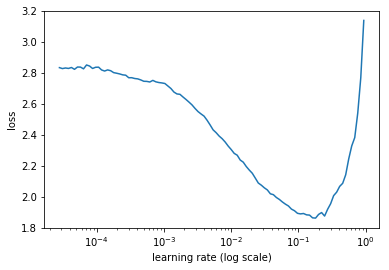

In [72]:
learn.sched.plot()

In [73]:
learn.fit(0.05, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   f1                         
    0      1.307097   0.648996   0.784645  
    1      0.813117   0.446592   0.848843                    
    2      0.588462   0.459823   0.846759                    



[0.45982295, 0.8467592592592593]

In [74]:
learn.precompute = False

In [75]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 87%|████████▋ | 117/134 [00:10<00:01, 11.08it/s, loss=3.01] 

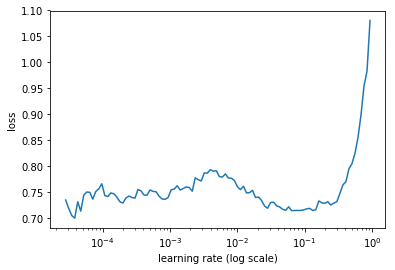

In [76]:
learn.sched.plot()

In [77]:
learn.fit(1e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

 68%|██████▊   | 91/134 [00:08<00:03, 11.14it/s, loss=0.616]

Exception in thread Thread-100:
Traceback (most recent call last):
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   f1                          
    0      0.603253   0.362907   0.863426  
    1      0.565802   0.352185   0.871759                    
    2      0.543662   0.359667   0.863426                    



[0.35966745, 0.8634259259259259]

In [78]:
learn.save("resnet50_224_1")

In [133]:
learn.load("resnet50_224_1")

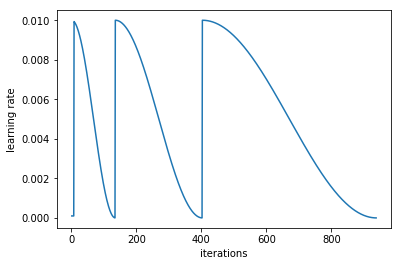

In [134]:
learn.sched.plot_lr()

In [135]:
learn.unfreeze()

In [118]:
lr = np.array([1e-5, 1e-3, 1e-1])

In [119]:
learn.fit(lr, 4, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

epoch      trn_loss   val_loss   f1                          
    0      0.462855   0.225734   0.911728  
    1      0.345987   0.160816   0.930864                    
    2      0.21457    0.147453   0.945833                    
    3      0.259057   0.168216   0.947917                    
    4      0.201206   0.126897   0.952083                    
    5      0.13622    0.107604   0.9625                      
    6      0.123171   0.102674   0.964583                    
    7      0.182828   0.133567   0.954167                    
    8      0.165891   0.117034   0.958333                    
    9      0.119618   0.133783   0.952083                    
    10     0.109987   0.109528   0.958333                    
    11     0.090207   0.096927   0.970833                     
    12     0.071897   0.09872    0.970833                     
    13     0.065876   0.092933   0.977083                     
    14     0.058899   0.097298   0.970833                     



[0.09729802, 0.9708333333333333]

In [136]:
lr = np.array([1e-4, 1e-2, 1e-1])

In [137]:
learn.fit(lr, 4, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

epoch      trn_loss   val_loss   f1                          
    0      0.538742   0.257822   0.9125    
    1      0.438864   0.176796   0.933333                    
    2      0.245762   0.164516   0.94375                     
    3      0.314494   0.245811   0.920062                    
    4      0.256515   0.190568   0.936728                    
    5      0.15915    0.112453   0.95625                     
    6      0.122806   0.11396    0.962114                    
    7      0.247175   0.208081   0.941281                    
    8      0.21155    0.18746    0.933333                    
    9      0.154647   0.149283   0.95                        
    10     0.157082   0.133076   0.954167                    
    11     0.095554   0.081409   0.975                        
    12     0.07437    0.075667   0.975                        
    13     0.048619   0.079325   0.975                        
    14     0.051943   0.076745   0.979167                     



[0.07674523, 0.9791666666666666]

In [138]:
learn.save("resnet50_224_2")

In [153]:
learn.load("resnet50_224_2")

In [154]:
lr = np.array([1e-18, 1e-12, 1e-10])

In [155]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f1                           
    0      0.068732   0.077794   0.975     
    1      0.053325   0.081698   0.979167                     
    2      0.061013   0.070972   0.98125                      
    3      0.064221   0.078533   0.977083                     
    4      0.061378   0.078259   0.975                        
    5      0.060261   0.076106   0.98125                      
    6      0.068881   0.073877   0.98125                      



[0.0738775, 0.98125]

In [156]:
learn.save("resnet50_224_3")

# Predict on test set

In [129]:
preds, _ = learn.TTA(is_test=True)

In [130]:
preds = np.mean(preds, 0)

In [131]:
final_preds = [data.classes[x].replace("_", " ") for x in np.argmax(preds, axis=1)]
fnames = [x.split("/")[1] for x in data.test_ds.fnames]

In [132]:
final = pd.DataFrame({'file': fnames, 'species': final_preds})

f = "submit12.csv"
final.to_csv(f"{PATH}{f}", index=False)

from IPython.display import FileLink
FileLink(f"{PATH}{f}")

/home/ubuntu/fastai/courses/dl1/data/plantseedings/submit12.csv